### (1)计算混淆矩阵

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

N = 100
th = 0.5 #阈值
seed = 4 # 随机种子
random.seed(seed)
# 随机产生数据集和A模型预测概率
label =[random.randint(0,1) for i in range(N)] 
pa= [random.random() for i in range(N)] 
A_pred_label = [1 if i>=th else 0 for i in pa] #A模型预测输出

# 随机产生B模型预测概率
pb = [random.random() for i in range(N)] 
B_pred_label = [1 if i>=th else 0 for i in pb] #B模型预测输出

def compute_4(label, y_pred):
    """计算二分类模型混淆矩阵所需要的四个参数"""
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(label)):
        if label[i] == 1 and y_pred[i] == 1: # 真正
           TP += 1
        if label[i] == 0 and y_pred[i] == 1: # 假正
           FP += 1
        if label[i] == 0 and y_pred[i] == 0: # 真负
           TN += 1
        if label[i] == 1 and y_pred[i] == 0: # 假负
           FN += 1
    return TP, FP, TN, FN
TP, FP, TN, FN = compute_4(label, A_pred_label)
cmA = [[TP,FN],[FP,TN]] # A模型混淆矩阵
TP, FP, TN, FN = compute_4(label, B_pred_label)
cmB = [[TP,FN],[FP,TN]]  # B模型混淆矩阵



Bad key "text.kerning_factor" on line 4 in
D:\Anaconda3\envs\deepLearning\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


画出混淆矩阵

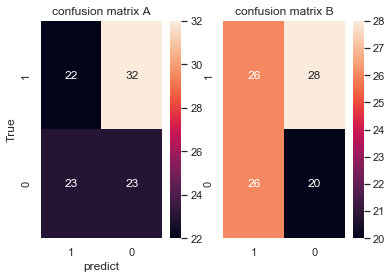

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
# 混淆矩阵可视化（热力图）
sns.set()
f, ax = plt.subplots(1,2) # 1行两列子图
g1 = sns.heatmap(cmA,annot=True,ax=ax[0]) # 画混淆矩阵热力图
ax[0].set_title('confusion matrix A')
ax[0].set_xlabel('predict')
g1.set_yticklabels(['1','0'])
g1.set_xticklabels(['1','0'])
ax[0].set_ylabel('True')
g2 = sns.heatmap(cmB,annot=True,ax=ax[1]) # 画混淆矩阵热力图
ax[1].set_title('confusion matrix B')
g2.set_yticklabels(['1','0'])
g2.set_xticklabels(['1','0'])

# 避免混淆矩阵数值偏移
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
ax[1].set_ylim(bottom + 0.5, top - 0.5)
plt.show()
# 每个混淆矩阵从左到右从上到下依次是[[TP,FN],[FP,TN]]

In [3]:
# pa_copy,pb_copy = pa.copy(), pb.copy()
sort_pa,sort_pb = sorted(pa,reverse=True), sorted(pb, reverse=True)
sort_pa_index = sorted(range(len(pa)), key=lambda k:pa[k], reverse=True)
sort_pb_index = sorted(range(len(pb)), key=lambda k:pb[k], reverse=True)
label_a = [label[i] for i in sort_pa_index] 
label_b = [label[i] for i in sort_pb_index]


# pre_A = [1 if i>]
def pr_roc_datas(label, y_scores):
    TPR=[]
    FPR=[]
    precision=[]
    recall=[]
    for th in y_scores:
        y_pred = [1 if score>=th else 0 for score in y_scores]
        TP, FP, TN, FN = compute_4(label, y_pred)
        precision.append(TP/(TP+FP))  #预测为正例的那些数据里预测正确的数据个数
        recall.append(TP/(TP+FN)) # 真实为正例的那些数据里预测正确的数据个数
        TPR.append(TP / (TP + FN))  # 在所有实际为阳性的样本中，被正确地判断为阳性的比率
        FPR.append(FP / (FP + TN))  #在所有实际为阴性的样本中，被错误地判断为阳性的比率
    return precision,recall,TPR,FPR 



(2)绘制PR曲线 precision = TP/(TP+FP)  recall=TP/(TP+FN)


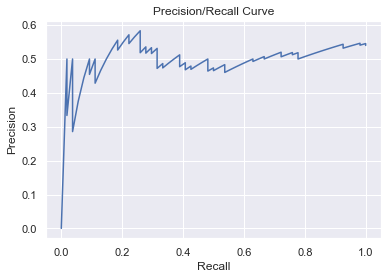

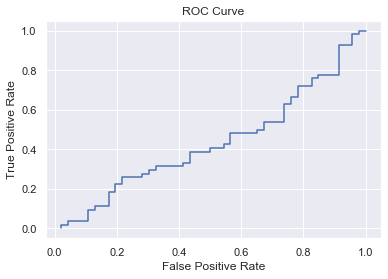

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

precision,recall,TPR,FPR = pr_roc_datas(label_b,sort_pb)
# precision,recall,TPR,FPR = pr_roc_datas(label_b,sort_pb)
plt.figure("P-R Curve")
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
#y_true为样本实际的类别，y_scores为样本为正例的概率

p1, = plt.plot(recall,precision)

# (3)绘制roc曲线
plt.figure("ROC Curve")
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# plt.plot(recall,precision)
plt.plot(FPR,TPR)

plt.show()


（4）模拟两个模型AB的十次交叉验证结果，利用t检验判断模型好坏

（4）将A、B模型的N个数据随机打散，分为10组，每一组间隔取样，取10次形成每次的数据集，分别计算A、B模型十组数据的错误率，平均错误率，方差，最后计算τt，定一个检验的置信度，评估A、B模型。

In [5]:
import math
k = 10 # k折交叉验证
n = int(N/k) # 每一组包含的样本数
def shuffle_data(labels, scores1, scores2): # 将数据打散划分为n组，每组batch_size个
    state = random.getstate() # 用同样的方式打乱label和模型输出概率score
    random.shuffle(labels) # 将标签打乱
    random.setstate(state) # 保证打乱方式相同
    random.shuffle(scores1) # 将预测也按照同样的方式打乱
    random.setstate(state) # 
    random.shuffle(scores2) #

def judge(score): # 判断该分为正类还是负类
    if score>=0.5:
        return 1
    else:
        return 0
def classify(scores):
    """输入预测为正类的概率（是list）
    返回预测的标签"""
    return [judge(score) for score in scores]


def compute_error_rate(label, pred, n):
    """n表示每一折中的数据个数;需保证label的length能整除n"""
    num_err = 0 #一折中错误的个数
    errors = [] #k折交叉验证每一折的测试错误率
    for i in range(0,len(label),n): # 计算第i折的测试错误率
        for j in range(n):
            if i+j >= len(label):
                print("数组越界")
                break
            if label[i+j] != pred[i+j]:
                num_err += 1
        errors += [num_err/n] # 列表每个元素代表每一折的错误率
        num_err = 0
    return errors

shuffle_data(label, pa, pb)
pred_A, pred_B = classify(pa), classify(pb)
er_rate_A = compute_error_rate(label, pred_A, n) # 计算AB错误率
er_rate_B = compute_error_rate(label, pred_B, n)

mean_A = sum(er_rate_A) / len(er_rate_A) # 求平均错误率，没用到
mean_B = sum(er_rate_B) / len(er_rate_B)

# er_rate_A,er_rate_B
# sub
# mean_A,mean_B

In [6]:
# 在置信度α=0.05的情况下 k=10的临界值为2.262
sub_AB = [abs(i-j) for i,j in zip(er_rate_A,er_rate_B)] # k对测试错误率相减
u = sum(sub_AB) / len(sub_AB)
var = sum((li-u)**2 for li in sub_AB) / len(sub_AB)  # 计算方差
std = math.sqrt(var)
taot = abs(math.sqrt(k)*u / std)
print(f'查表可知其α=0.05的情况下 k=10的临界值为2.262 而计算得τt={taot:.4f} > 2.262 \n故拒绝原假设，并接受备择假设“A B两个模型有显著性差异”')
if mean_A < mean_B:
    print(f'由于A的平均错误率={mean_A:.4f} 小于 B的平均错误率{mean_B:.4f}, 故认为A模型更好')
else:
    print(f'由于A的平均错误率={mean_A:.4f} 大于 B的平均错误率{mean_B:.4f}, 故认为B模型更好')

查表可知其α=0.05的情况下 k=10的临界值为2.262 而计算得τt=4.6291 > 2.262 
故拒绝原假设，并接受备择假设“A B两个模型有显著性差异”
由于A的平均错误率=0.5500 大于 B的平均错误率0.5400, 故认为B模型更好
